### Capstone: Leveraging NLP for Improved Movie Rating Predictions

Part 1

Author: Michael Rong

Date: April 3rd, 2023

1. Project Introduction

2. Introduction to the Notebook
    
    a. Data Dictionary
   
3. Initial Exploration of the Data

4. Advanced EDA and Feature Engineering

5. Notebook Conclusion

# Project Introduction

   In this project, we will be exploring two datasets acquired from MovieLens in order to explore how different features, most importantly text analysis can better help predict user ratings. MovieLens is a group that collects and organizes movie data to recommend movies to users.

Given that text analysis is currently a trending topic in our technologically advancing world, the purpose of this project is to investigate whether we can use NLP (Natural Language Processing) to analyze the sentiment expressed in the review text and determine if this analysis can improve the prediction accuracy of our machine learning models.

Additionally, we plan to extract from the datasets the words that carry the most significance or weight in the reviews. The project will involve a detailed exploration of the data, cleaning, feature engineering, sentiment analysis, and feature different machine learning models. At the end of the project, next steps will be outline that can help enhance the project to create more meaningful data.

# Introduction to the Notebook

In this notebook, we will be working with a large movie dataset and performing various data processing tasks, including exploration, cleaning, and feature engineering. The dataset contains a wide range of information about movies, such as their titles, genres, release dates, ratings, and more. Additionally, Feature Engineering using will be done to create more easily interpretable columns for our project.

By the end of the notebook, we will have a processed dataset that will be saved as a CSV for use in consequent notebook.s

## Data Dictionary

A data dictionary of the two datasets which we will be exploring will be provided for more interpretability of the columns.

raw/metadata.json
--------
The file contains information about movies from MovieLens - 84,661 lines of json objects that have the following fields:

title – Movie title, accompanied by year of release

directedBy – Director(s) of the movie

starring – Actors featured in the movie

dateAdded – Date in which the movie was added to the MovieLens database

avgRating – average rating of a movie on scale of 0.5 to 5

imdbId – Movie ID, corresponding to the IMDB website

item_id – Movie ID, which is consistent across the MovieLens datasets being used.


raw/reviews.json
--------
The file contains 2,624,608 lines of movie reviews collected from the IMDB website. The json objects have the following fields:

item_id – Movie ID, which is consistent across the MovieLens datasets being used.

txt – review text

# Initial Exploration of the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',100000000)

### Movies

In [2]:
# Reading the Movies dataset

metadata_raw = pd.read_json(r"C:\Users\micha\OneDrive\Desktop\Capstone\movie_dataset_public_final\raw\metadata.json", lines=True)

In [3]:
# taking a look at the first 5 entries

metadata_raw.head()

,title,directedBy,starring,dateAdded,avgRating,imdbId,item_id
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",None,3.89146,114709,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",None,3.26605,113497,2
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",None,3.17146,113228,3
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",None,2.86824,114885,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",None,3.07620,113041,5


From an initial glance, we can see we have various columns give information about the Movie, the directors, actors, as well as the average rating corresponding to the movie. There are also columns such as imdbid and item_id that are used to index the movies somewhere. We will take a look at the basic structure of the dataset.

In [4]:
# Finding the shape we have ~ 85 thousand entries and 7 columns

metadata_raw.shape

(84661, 7)

In [5]:
# Getting info on the datatypes as well as entries that are non null
metadata_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       84661 non-null  object 
 1   directedBy  84661 non-null  object 
 2   starring    84661 non-null  object 
 3   dateAdded   78143 non-null  object 
 4   avgRating   84661 non-null  float64
 5   imdbId      84661 non-null  int64  
 6   item_id     84661 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 4.5+ MB


Upon getting the datatypes, we can see that directedBy, starring, and dateAdded seem to have a substantial amount of missing entries. we will attempt to remove all the null values as entries will not be usable if the corresponding columns are not filled in.

To make the cleaning process easier, we will also be dropping the dateAdded, and imdbId columns as they do not give meaninful details about the movie itself like the number of actors or the director does.

As part of the cleaning process, to be thorough, we will also be replacing empty entries with Null or 'NaN' values. This is due to empty entries not giving us any data to work with, as well as interfering with the processing of our dataset.

In [6]:
# Replaces all white space entries with 'NaN'

metadata_raw = metadata_raw.replace(r'^\s*$', pd.np.nan, regex=True)

In [7]:
# Getting the info again, we see there are more null values than initially thought

metadata_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       84661 non-null  object 
 1   directedBy  81511 non-null  object 
 2   starring    77778 non-null  object 
 3   dateAdded   78143 non-null  object 
 4   avgRating   84661 non-null  float64
 5   imdbId      84661 non-null  int64  
 6   item_id     84661 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 4.5+ MB


In [8]:
# Find the percentage of each column with missing data

metadata_raw.isna().sum(axis=0) / metadata_raw.shape[0]*100

title         0.000000
directedBy    3.720721
starring      8.130072
dateAdded     7.698940
avgRating     0.000000
imdbId        0.000000
item_id       0.000000
dtype: float64

Before dropping values, we know that dateAdded is different than the year the movie is released in, we will be dropping this as to not interfere with the rest of the data. In addition, imdbID will be dropped as it is not useful to predicting our target variable, and will not be used to join datasets in a later section.

In [9]:
# Dropping specified columns.

metadata_raw.drop(columns=['dateAdded', 'imdbId'], inplace=True)  

In [10]:
# Drop all rows that contain NaN values

metadata_raw = metadata_raw.dropna()

In [11]:
#, Checking for duplicate entries

metadata_raw.duplicated().sum()

0

On initial exploration, it seems like there are substantial amounts of data missing in certain columns, due to the size of this dataset, we will not be able to locate all the directors and starring actors of each film and add them manually. We have decided to drop these missing values from the data set.

We also notice that the title of the movie contains the year as well in brackets. We will be creating a new column called Year, finding all year values at the end of each movie, and extracting them as a string.

In [12]:
# gets the text from a string ending in round brackets with 4 numbers inside.

metadata_raw['Year'] = metadata_raw['title'].str.extract(r'\((\d{4})\)$')

Viewing the dataset once again, we seem to have been successful in getting the Year column

In [13]:
metadata_raw.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",3.89146,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",3.26605,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",3.17146,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",2.86824,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",3.07620,5,1995


In [14]:
# 0.5 percent of the year column is missing, we 
metadata_raw.isna().sum(axis=0) / metadata_raw.shape[0]*100

title         0.00000
directedBy    0.00000
starring      0.00000
avgRating     0.00000
item_id       0.00000
Year          0.53443
dtype: float64

In [15]:
# Change Data type so it's numerical
metadata_raw['Year'] = metadata_raw['Year'].astype('Int64')

In [16]:
metadata_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76343 entries, 0 to 84659
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       76343 non-null  object 
 1   directedBy  76343 non-null  object 
 2   starring    76343 non-null  object 
 3   avgRating   76343 non-null  float64
 4   item_id     76343 non-null  int64  
 5   Year        75935 non-null  Int64  
dtypes: Int64(1), float64(1), int64(1), object(3)
memory usage: 4.1+ MB


In [17]:
metadata_raw.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",3.89146,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",3.26605,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",3.17146,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",2.86824,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",3.07620,5,1995


In [18]:
# checking for null values in the Year column
metadata_raw.isna().sum(axis=0) / metadata_raw.shape[0]*100

title         0.00000
directedBy    0.00000
starring      0.00000
avgRating     0.00000
item_id       0.00000
Year          0.53443
dtype: float64

Upon checking the entries with missing years, we can tell they are all individual movies. We will choose to drop the data again as it is too many entries to manually add into the dataset.

In [19]:
# Sampling 5 movies with no year values.
metadata_raw[metadata_raw['Year'].isna()].sample(5)

,title,directedBy,starring,avgRating,item_id,Year
65056,Anatolian Trip,Deniz Tortum,"Cem Celal Bilge,Derin Emre,Mustafa C. Aydın,Uğur Deynekli,Mert Coşar",2.16667,200000,<NA>
19520,Hierro (2009),Gabe Ibáñez,"Elena Anaya, Bea Segura, Mar Sodupe, Andrés Herrera, Miriam Correa, Kaiet Rodríguez, Javier Mejía, Hugo Arbues, Raquel Salvador, Jorge Lobo, Jon Ariño, Tomás del Estal, Pepe González Rubio",3.03125,96034,<NA>
35692,The Near Room,David Hayman,"Adrian Dunbar,David O'Hara,David Hayman,Julie Graham,Robert Pugh",2.00000,140129,<NA>
21883,"World According to Dick Cheney, The (2013)",R.J. Cutler,"Dick Cheney, Lynne Cheney, Dennis Haysbert",3.41667,104599,<NA>
22471,"Chameleon, The (2010)",Jean-Paul Salomé,"Marc-André Grondin, Ellen Barkin, Famke Janssen, Emilie de Ravin, Tory Kittles, Brian Geraghty, Nick Stahl",2.46774,106501,<NA>


In [20]:
# Keeps all data where 'Year' column is not empty

metadata_raw = metadata_raw[pd.notnull(metadata_raw['Year'])]

In [21]:
# Looks like the data is relatively clean

metadata_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75935 entries, 0 to 84659
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       75935 non-null  object 
 1   directedBy  75935 non-null  object 
 2   starring    75935 non-null  object 
 3   avgRating   75935 non-null  float64
 4   item_id     75935 non-null  int64  
 5   Year        75935 non-null  Int64  
dtypes: Int64(1), float64(1), int64(1), object(3)
memory usage: 4.1+ MB


After cleaning the data, we will be exploring the numerical columns and assessing how the data is distributed in our dataset. Let's start with the Year column.

In [22]:
# Checking the distribution of the 'Year' column

metadata_raw['Year'].describe()

count    75935.000000
mean      1993.618108
std         24.946430
min       1880.000000
25%       1978.000000
50%       2003.000000
75%       2013.000000
max       2021.000000
Name: Year, dtype: float64

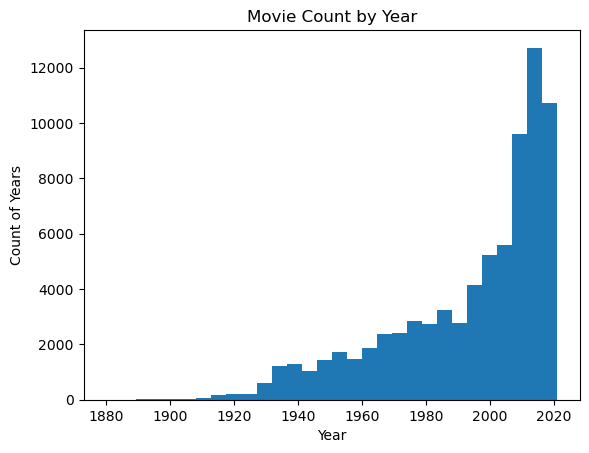

In [23]:
# Plotting histogram of number of movies across the years

plt.hist(metadata_raw['Year'].values, bins=30)

plt.title('Movie Count by Year')
plt.xlabel('Year')
plt.ylabel('Count of Years')
plt.show()

The histogram shows the number of movies made across the years, this was performed just to do a quality check in case there were any outlier numbers in the data which we may have missed, from the plot, we can also see that the majority of the data resides in more recent films from 2000 to 2020.

The next column we would like to assess is the avgRating column, to make the rating scale simpler, we will change the rating from a scale of 0.5 - 5, to a scale of 1 - 10.

In [24]:
# multipler to bring the values of movie reviews from a range of 0.5-5 to 1-10

metadata_raw['avgRating'] = metadata_raw['avgRating'].multiply(2)

In [25]:
# viewing data again
# can see there are numbers exceeding 5 for 'avgRating' now

metadata_raw.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78292,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53210,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34292,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.73648,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15240,5,1995


In [26]:
# rounding all ratings to 2 decimal place.

metadata_raw['avgRating'] = metadata_raw['avgRating'].round(2)


In [27]:
# look at the distribution of numbers

metadata_raw['avgRating'].describe()

count    75935.000000
mean         5.093611
std          2.600895
min          0.000000
25%          4.200000
50%          6.000000
75%          6.930000
max         10.000000
Name: avgRating, dtype: float64

From the statistical information we get above, we see that the minimum value in the ratings column is 0, we will need to remove these from the dataset, we will be doing so by only keeping entries which have an average rating of 1 or higher, as the original scale was from 0.5 to 5.

In [28]:
# Filter and keep columns that have an average rating of 1 or higher

cleaner_df = metadata_raw[(metadata_raw['avgRating']>=1)]

In [29]:
cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995


In [30]:
# checking size again

cleaner_df.shape

(63769, 6)

In [31]:
# minimum value of avg rating is now 1
cleaner_df['avgRating'].describe()

count    63769.000000
mean         6.065382
std          1.470032
min          1.000000
25%          5.290000
50%          6.210000
75%          7.000000
max         10.000000
Name: avgRating, dtype: float64

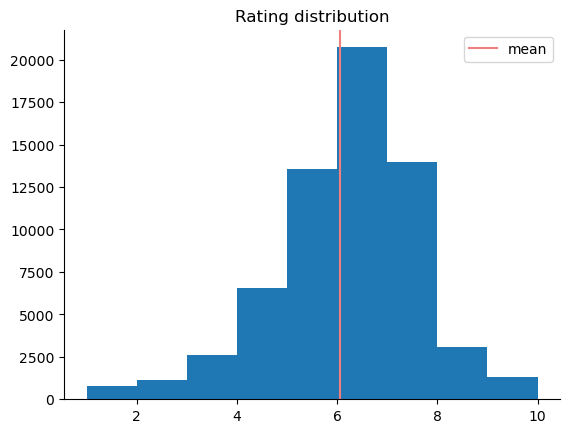

In [32]:
# histogram plot, 
plt.hist(cleaner_df['avgRating'], bins=9)

# Plots mean 
plt.axvline(cleaner_df['avgRating'].mean(), 0, 1000, label="mean", color="lightcoral")

plt.title("Rating distribution")
sns.despine()
plt.legend()
plt.show()

Upon plotting the distribution of ratings, there seems to almost be a normal distribution from 1-10, with it being slightly more focused on the right side, with the most concentrated part of the data being around 6 to 7 with a mean of 6.05. We will be revisiting this visualization later in the next section of the notebook.

# Advanced EDA and Feature Engineering

After exploring the numerical columns as well as cleaning the data, we will be addressing the categorical columns as well as creating new columns for more interpretability.

Let's take a look at what our data set looks like.

In [33]:
cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995


Going back to the distribution of average rating, we will be creating a sentiment column which will aid in the process of our sentiment analysis using Natural Language Processing. The sentiment column will consist of a column of 1 and 0, where 1 represents a good sentiment, and 0 represents a negative sentiment in the reviews. 

For our decision, we will choose a rating of 7 or higher to represent a positive sentiment.

In [34]:
# Create a sentiment column if rating is 7.0 or above, 1

cleaner_df['Sentiment'] = np.where(cleaner_df['avgRating'] >= 7, 1, 0)
cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0


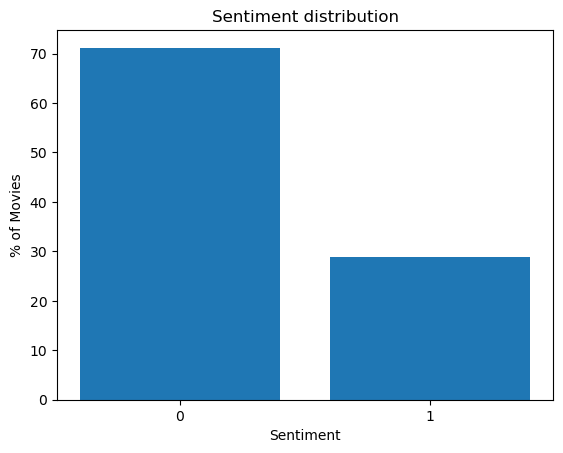

Class imbalance: [0.71 0.29]


In [35]:
# Plot the distribution of the new column

values, counts = np.unique(cleaner_df['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()

plt.title("Sentiment distribution")
plt.bar(["0", "1"], normalized_counts*100) # plot normalized counts
plt.xlabel('Sentiment')
plt.ylabel('% of Movies')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

After creating the sentiment column, we will look at the directedBy column, we cannot quantify meaning data just from names, so we can attempt to get the count of the directors per movie to see if there are any values over 1.

In [36]:
# we can assume that theres only one director per movie, but maybe there's an additional credit, lets count the number of comma seperated items in each directedBy entry

cleaner_df['director_count'] = cleaner_df['directedBy'].str.split(",").apply(len)

In [38]:
# taking 20 entries

cleaner_df.head(20)

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,director_count
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0,1
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0,1
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0,1
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0,1
5,Heat (1995),Michael Mann,"Robert De Niro, Al Pacino, Val Kilmer, Jon Voight, Tom Sizemore, Ashley Judd, Diane Venora, Natalie Portman",7.71,6,1995,1,1
6,Sabrina (1995),Sydney Pollack,"Harrison Ford, Greg Kinnear, Nancy Marchand, Julia Ormond",6.74,7,1995,0,1
7,Tom and Huck (1995),Peter Hewitt,"Jonathan Taylor Thomas, Brad Renfro, Eric Schweig, Charles Rocket, Amy Wright, Michael McShane, Marian Seldes, Rachael Leigh Cook, Peter Mackenzie, Andy Stahl, Adrian Roberts, David Cowgill, Ike Eisenmann, Tamara Mello, Courtney Peldon",6.23,8,1995,0,1
8,Sudden Death (1995),Peter Hyams,"Raymond J. Barry, Powers Boothe, Jean-Claude Van Damme, Whittni Wright",6.00,9,1995,0,1
9,GoldenEye (1995),Martin Campbell,"Pierce Brosnan, Sean Bean, Famke Janssen, Izabella Scorupco, Joe Don Baker, Judi Dench, Robbie Coltrane, Alan Cumming, Tchéky Karyo, Desmond Llewelyn, Samantha Bond",6.87,10,1995,0,1


On the 17th indexed entry, the movie titled ' Four Rooms' has a 4 names credited for the directors. We will see if there are any more with multiple directors.

In [39]:
# number of counts for directors counts

cleaner_df['director_count'].value_counts()

1     62035
2      1473
3       144
4        38
5        22
7        16
6        15
8         7
11        4
9         3
13        2
10        2
26        2
36        1
25        1
15        1
12        1
27        1
30        1
Name: director_count, dtype: int64

A large portion of them seem to be a single director, with 2 or 3 also having some weight to it, let's see the percentages of values with the number of directors.

From getting the proportional data, we see that 97% of the data consists of only 1 director, for a large dataset, we find this will be more likely to drop the remainder as there are many outlier cases such as having 4, 5, 6, and onwards number of directors.

We will do this by removing the 'director_count' column as they will all be 1 director per movie, and only taking the first name in the entry for 'directedBy'

In [40]:
# Percent that the value shows up

cleaner_df['director_count'].value_counts(normalize = True)

1     0.972808
2     0.023099
3     0.002258
4     0.000596
5     0.000345
7     0.000251
6     0.000235
8     0.000110
11    0.000063
9     0.000047
13    0.000031
10    0.000031
26    0.000031
36    0.000016
25    0.000016
15    0.000016
12    0.000016
27    0.000016
30    0.000016
Name: director_count, dtype: float64

In [41]:
# Dropping director_count

cleaner_df.drop(columns=['director_count'], inplace=True)

In [42]:
# Taking the first name in the directedBy column

cleaner_df['directedBy'] = cleaner_df['directedBy'].str.split(',').str[0]

In [43]:
cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0


We would also like to get the number of movies directed by each director, to do so, we will count the number of entries that has this director's name, and sum the total. These values with be stored in a new column.

In [44]:
# Creates new column showing number of movies directed by the corresponding director

cleaner_df['#Movies_directed'] = cleaner_df.groupby('directedBy')['directedBy'].transform('count')

In [45]:
# Taking a look at the Data again

cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,#Movies_directed
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1,6
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0,9
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0,11
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0,7


Before we continue, we want to explore if the experience a director has might have an impact on the movie ratings. Let's create a plot to compare the number of movies they made to their average rating

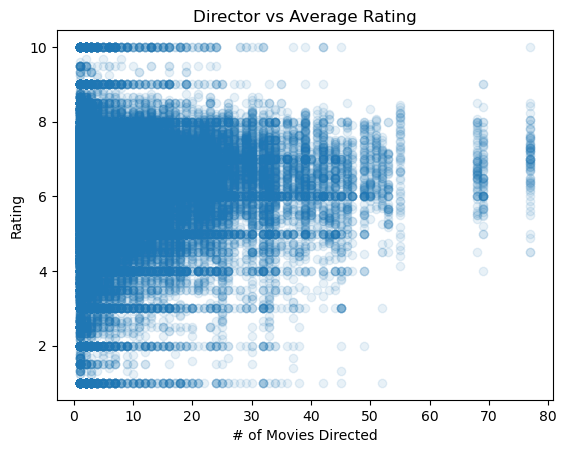

In [46]:
plt.figure()

plt.scatter(cleaner_df['#Movies_directed'], cleaner_df['avgRating'], alpha=0.1) # change the transparency with the alpha param, between 0 and 1

plt.xlabel('# of Movies Directed')
plt.ylabel('Rating')
plt.title('Director vs Average Rating')

plt.show()

From this, we can tell that experience does make for more consistent ratings, however we still see that there are people who make few movies with really good ratings for their movies. The data does not signify anything valuable to take but it could help in our prediction models.

Now, we will address the actor count columns

In [47]:
# Gets a column counting by actors, we see it's seperated by commas

cleaner_df['actor_count'] = cleaner_df["starring"].str.count(",") + 1

In [48]:
# 5 actors is the starring list's most common

cleaner_df['actor_count'].value_counts(normalize = True)

5     0.518104
4     0.173878
3     0.100488
1     0.044771
2     0.043908
6     0.034280
7     0.020214
8     0.014239
9     0.010068
10    0.007731
11    0.006414
12    0.005206
13    0.003999
15    0.003324
14    0.003152
16    0.001678
17    0.001600
18    0.001443
20    0.000862
19    0.000831
21    0.000800
22    0.000455
24    0.000376
23    0.000282
29    0.000251
25    0.000235
28    0.000220
26    0.000220
27    0.000188
30    0.000157
31    0.000110
32    0.000094
35    0.000063
41    0.000047
36    0.000047
33    0.000031
34    0.000031
37    0.000031
40    0.000031
57    0.000031
70    0.000016
38    0.000016
45    0.000016
52    0.000016
51    0.000016
65    0.000016
42    0.000016
Name: actor_count, dtype: float64

We see that the most common credit actors list is around 5 credited for this data set, we will see if we sum the movies starting with 1 actor and keep ascending where the data set has a good represented portion.

In [49]:
# 5 actors also makes up almost 90% of the dataset.
# limit it to top 5 actors.

cleaner_df['actor_count'].value_counts(normalize=True).sort_index().cumsum()

1     0.044771
2     0.088679
3     0.189167
4     0.363045
5     0.881149
6     0.915429
7     0.935643
8     0.949882
9     0.959949
10    0.967680
11    0.974094
12    0.979300
13    0.983299
14    0.986451
15    0.989776
16    0.991454
17    0.993053
18    0.994496
19    0.995327
20    0.996189
21    0.996989
22    0.997444
23    0.997726
24    0.998103
25    0.998338
26    0.998557
27    0.998745
28    0.998965
29    0.999216
30    0.999373
31    0.999483
32    0.999577
33    0.999608
34    0.999639
35    0.999702
36    0.999749
37    0.999780
38    0.999796
40    0.999828
41    0.999875
42    0.999890
45    0.999906
51    0.999922
52    0.999937
57    0.999969
65    0.999984
70    1.000000
Name: actor_count, dtype: float64

By doing cumulative sum on the 'actor_count' column, we see that close to 90% of data consists of 5 credited actors or less in their movies. We will reduce the actor count to only show a maximum of 5 actors, as we will be using this to create a new feature later.

In [50]:
cleaner_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63769 entries, 0 to 84561
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             63769 non-null  object 
 1   directedBy        63769 non-null  object 
 2   starring          63769 non-null  object 
 3   avgRating         63769 non-null  float64
 4   item_id           63769 non-null  int64  
 5   Year              63769 non-null  Int64  
 6   Sentiment         63769 non-null  int32  
 7   #Movies_directed  63769 non-null  int64  
 8   actor_count       63769 non-null  int64  
dtypes: Int64(1), float64(1), int32(1), int64(3), object(3)
memory usage: 4.7+ MB


In [51]:
# map anyhting over 5 to 5

cleaner_df['actor_count'] = np.where(cleaner_df['actor_count'] >= 5, 5, cleaner_df['actor_count'])

In [52]:
cleaner_df['actor_count'].value_counts(normalize = True)

5    0.636955
4    0.173878
3    0.100488
1    0.044771
2    0.043908
Name: actor_count, dtype: float64

After editing the column to only show the first 5 actors, we will create a new dataset, where we will assign the actors to their own columns from actor 1 to actor 5, if there is no actor to fill, a 0 will show up in it's place.

In [53]:

actors_list = []

for index, row in cleaner_df.iterrows():
    # Split the "starring" column by commas to get a list of actors
    cols = row['starring'].split(",")
    if len(cols) < 5:
        cols += [0] * (5 - len(cols))
    else:
        cols = cols[:5]
    
    # Add the list of actors to the list of actor lists
    actors_list.append(cols)

# make it a dataframe
actors_df = pd.DataFrame(actors_list, columns=['Actor 1', 'Actor 2', 'Actor 3', 'Actor 4', 'Actor 5'])

# Look at new table
actors_df.head()

,Actor 1,Actor 2,Actor 3,Actor 4,Actor 5
0,Tim Allen,Tom Hanks,Don Rickles,Jim Varney,John Ratzenberger
1,Jonathan Hyde,Bradley Pierce,Robin Williams,Kirsten Dunst,0
2,Jack Lemmon,Walter Matthau,Ann-Margret,Sophia Loren,0
3,Angela Bassett,Loretta Devine,Whitney Houston,Lela Rochon,0
4,Steve Martin,Martin Short,Diane Keaton,Kimberly Williams,George Newbern


In [54]:
print(actors_df.shape)

(63769, 5)


We plan to create a new feature, called 'Celeb_score', which is the total appearances of the actors in movies, divided by the number of actors in the movie, the process will be displayed below.

In [68]:
# exclude 0s
# Flatten the dataframe and count the appearances of each actor
actor_counts = actors_df.stack().value_counts()

# Create a new dataframe with total appearances for each row
total_appearances_df = pd.DataFrame()
for index, row in actors_df.iterrows():
    actors = [actor for actor in row.values if actor != 0]
    total_appearances = actor_counts.loc[actors].sum()
    total_appearances_df = total_appearances_df.append(pd.DataFrame({'total_appearances': [total_appearances]}), ignore_index=True)


In [69]:

# Display the new dataframe
total_appearances_df.head()

,total_appearances
0,66
1,52
2,80
3,33
4,75


In [70]:
# combine the appearance number with the actors dataframe
actors_appearances_df = pd.concat([actors_df.reset_index(drop=True), total_appearances_df.reset_index(drop=True)], axis = 1)

In [71]:
# append the actors dataframe to the original dataset
# Reset index to avoid adding new rows
movies_df = pd.concat([cleaner_df.reset_index(drop=True), actors_appearances_df.reset_index(drop=True)], axis = 1)

In [72]:
movies_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,#Movies_directed,actor_count,Actor 1,Actor 2,Actor 3,Actor 4,Actor 5,total_appearances
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1,6,5,Tim Allen,Tom Hanks,Don Rickles,Jim Varney,John Ratzenberger,66
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0,9,4,Jonathan Hyde,Bradley Pierce,Robin Williams,Kirsten Dunst,0,52
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0,11,4,Jack Lemmon,Walter Matthau,Ann-Margret,Sophia Loren,0,80
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0,4,4,Angela Bassett,Loretta Devine,Whitney Houston,Lela Rochon,0,33
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0,7,5,Steve Martin,Martin Short,Diane Keaton,Kimberly Williams,George Newbern,75


In [73]:
movies_df['Celeb_score'] = movies_df['total_appearances'] / movies_df['actor_count']



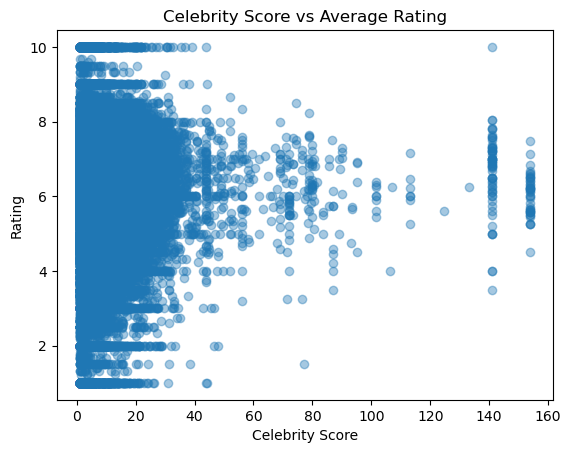

In [74]:
plt.figure()

plt.scatter(movies_df['Celeb_score'], movies_df['avgRating'], alpha=0.4) # change the transparency with the alpha param, between 0 and 1

plt.xlabel('Celebrity Score')
plt.ylabel('Rating')
plt.title('Celebrity Score vs Average Rating')

plt.show()

Plotting the rating versus the celebrity score, shows us a similar pattern as we do in the plot of movies directed versus rating, where the range of ratings is much wider if the actors show up in less movies or have less experience, but ratings stabilize at higher celebrity score values.

In [75]:
# Drop total_appearances as it will not be necessary for future use.

movies_df.drop(columns=['total_appearances'], inplace=True)

In [76]:
movies_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,#Movies_directed,actor_count,Actor 1,Actor 2,Actor 3,Actor 4,Actor 5,Celeb_score
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1,6,5,Tim Allen,Tom Hanks,Don Rickles,Jim Varney,John Ratzenberger,13.20
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0,9,4,Jonathan Hyde,Bradley Pierce,Robin Williams,Kirsten Dunst,0,13.00
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0,11,4,Jack Lemmon,Walter Matthau,Ann-Margret,Sophia Loren,0,20.00
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0,4,4,Angela Bassett,Loretta Devine,Whitney Houston,Lela Rochon,0,8.25
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0,7,5,Steve Martin,Martin Short,Diane Keaton,Kimberly Williams,George Newbern,15.00


In [77]:
# no nulls and everything seems so have the right data type
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63769 entries, 0 to 63768
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             63769 non-null  object 
 1   directedBy        63769 non-null  object 
 2   starring          63769 non-null  object 
 3   avgRating         63769 non-null  float64
 4   item_id           63769 non-null  int64  
 5   Year              63769 non-null  Int64  
 6   Sentiment         63769 non-null  int32  
 7   #Movies_directed  63769 non-null  int64  
 8   actor_count       63769 non-null  int64  
 9   Actor 1           63769 non-null  object 
 10  Actor 2           63769 non-null  object 
 11  Actor 3           63769 non-null  object 
 12  Actor 4           63769 non-null  object 
 13  Actor 5           63769 non-null  object 
 14  Celeb_score       63769 non-null  float64
dtypes: Int64(1), float64(2), int32(1), int64(3), object(8)
memory usage: 7.1+ MB


In [78]:
# Copy the dataset

linreg_movies_df = movies_df.copy()

In [79]:
linreg_movies_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,#Movies_directed,actor_count,Actor 1,Actor 2,Actor 3,Actor 4,Actor 5,Celeb_score
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1,6,5,Tim Allen,Tom Hanks,Don Rickles,Jim Varney,John Ratzenberger,13.20
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0,9,4,Jonathan Hyde,Bradley Pierce,Robin Williams,Kirsten Dunst,0,13.00
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0,11,4,Jack Lemmon,Walter Matthau,Ann-Margret,Sophia Loren,0,20.00
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0,4,4,Angela Bassett,Loretta Devine,Whitney Houston,Lela Rochon,0,8.25
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0,7,5,Steve Martin,Martin Short,Diane Keaton,Kimberly Williams,George Newbern,15.00


By this point, we should have a dataset which we will be able to use to join with our second dataset from MovieLens, the only thing we need to do is to drop the columns which will not contribute to our model.

In [80]:
# Drops columns

linreg_movies_df.drop(columns=['title', 'directedBy', 'starring','Actor 1', 'Actor 2', 'Actor 3', 'Actor 4', 'Actor 5'], inplace=True) 

In [81]:
# shows the info of the dataset
# Keeping item_id for a join in the future
linreg_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63769 entries, 0 to 63768
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avgRating         63769 non-null  float64
 1   item_id           63769 non-null  int64  
 2   Year              63769 non-null  Int64  
 3   Sentiment         63769 non-null  int32  
 4   #Movies_directed  63769 non-null  int64  
 5   actor_count       63769 non-null  int64  
 6   Celeb_score       63769 non-null  float64
dtypes: Int64(1), float64(2), int32(1), int64(3)
memory usage: 3.2 MB


A heatmap showing the correlation of the columns has also been created, from the heatmap, we can see that most of the features remaining do not have a high correlation, the only two that seem to have high correlation are the sentiment and average rating, which is understandable as one is derived from the other.

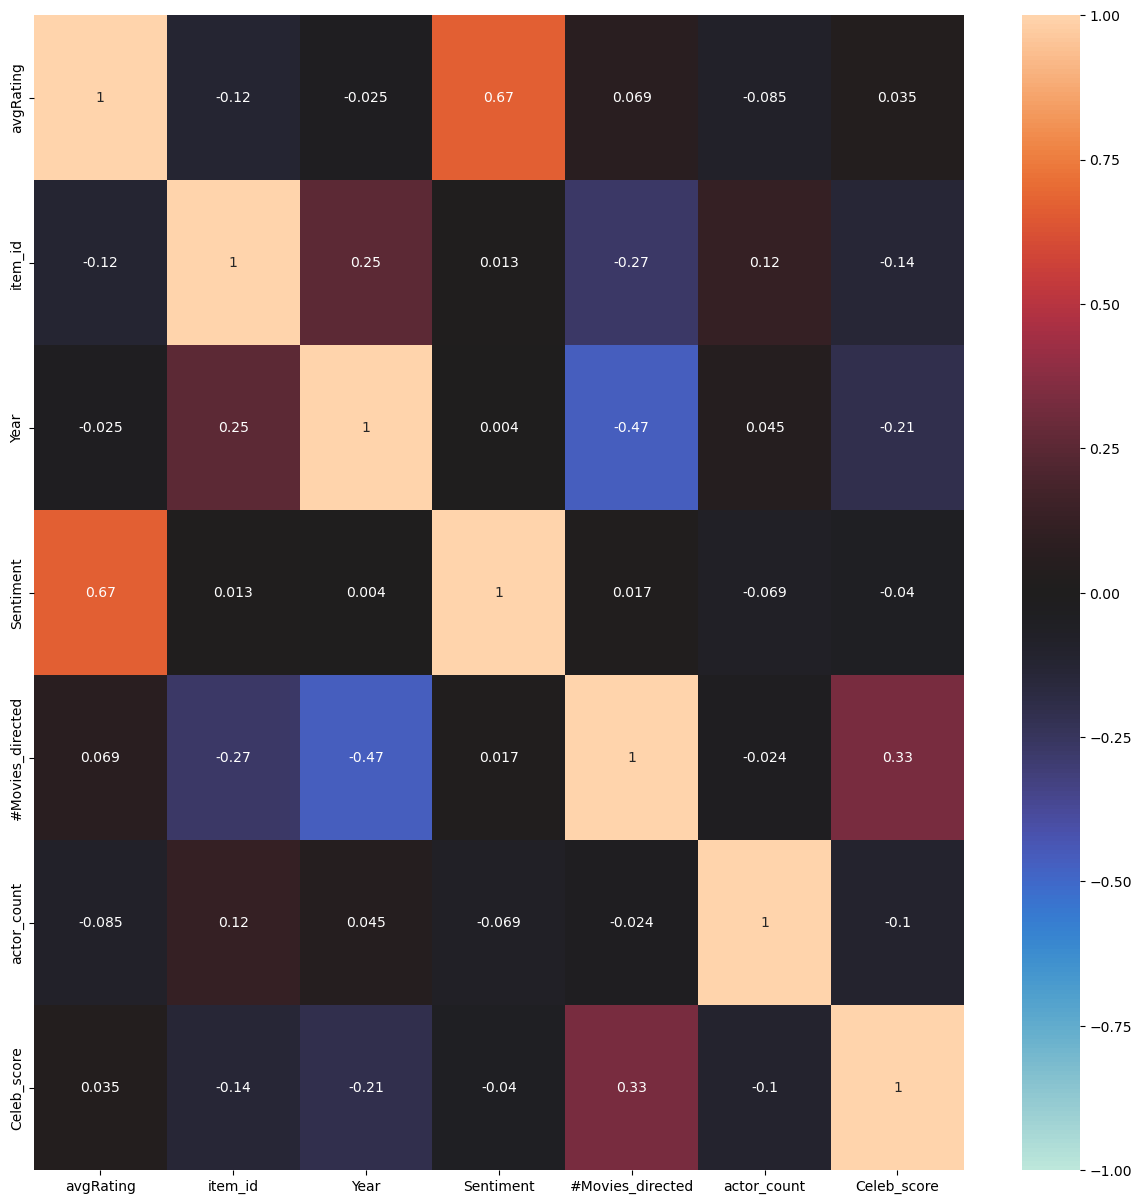

In [82]:
# actor count and celeb score seem to have a high correlation
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15,15))
sns.heatmap(linreg_movies_df.corr(), annot=True, center=0, vmin=-1, vmax=1)
plt.show()


In [79]:
# Let's save the cleaned movie dataset

linreg_movies_df.to_csv(r'C:\Users\micha\OneDrive\Desktop\Capstone\Processed_Data\lin_reg_movies.csv', index=False)

# Notebook Conclusion

In this notebook, we have introduced the project as a whole, and went through the process of cleaning and exploring the data of one of the datasets which we are using. The process demonstrates the cleaning, feature engineering, and also showcases several visualizations of the dataset. By the end of this notebook, we obtained a cleaned dataset and saved it as a CSV file for later use.

In the next notebook, we will be exploring the review text dataset, and analyzing the sentiment in the review text so we can prepare the data for use in machine learning models.